# Competition 2

In [1]:
import tensorflow as tf
print(tf.__version__)

2.10.1


In [2]:
import tensorflow as tf
import numpy as np
from abc import abstractmethod
import tensorflow.keras.layers as layers
from tensorflow.keras import Model, activations
from tensorflow.keras.layers import Layer
from datetime import datetime
# from tqdm.autonotebook import tqdm
from tqdm import tqdm
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess_input
import cv2 
import matplotlib.pyplot as plt
import random

# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import warnings
warnings.filterwarnings("ignore")

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 8
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
# DATA_PATH = './data/pascal_voc_training_data.txt'
DATA_PATH = './data/data_augmentation_pascal_voc_training_data_3000.txt'

# IMAGE_DIR = './data/VOCdevkit_train/VOC2007/JPEGImages/'
IMAGE_DIR = './data/VOC_Augmentation_train_3000/'

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-6
EPOCHS = 20

# Pretrain model config
PRETRAIN_MODEL = "resnet50"

pretrained_model_preprocess_input = None
if PRETRAIN_MODEL == "resnet50":
    pretrained_model_preprocess_input = resnet_preprocess_input
elif PRETRAIN_MODEL == "densenet121":
    pretrained_model_preprocess_input = densenet_preprocess_input
else:
    raise ValueError("Invalid pretrain model")

## Dataset

In [5]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

In [6]:
training_data_file = open(DATA_PATH, "r")
for i, line in enumerate(training_data_file):
    if i >5:
        break
    line = line.strip()
    print(line)

rt_or_same_0_000032.jpg 93 124 336 291 0 119 140 176 196 0 174 286 190 365 14 23 301 39 379 14
rt_or_same_0_000016.jpg 15 55 325 445 1
rt_or_same_0_000046.jpg 303 210 448 336 2
rt_or_same_0_000061.jpg 210 0 448 410 3 140 284 268 389 3
rt_or_same_0_000200.jpg 0 0 90 216 14 0 0 149 388 14 58 0 217 418 14 130 23 358 432 14 279 87 448 432 14 255 409 287 432 4 146 237 192 359 4
rt_or_same_0_000132.jpg 198 70 409 386 5


### Observe the data

In [7]:
class_counts = [[name, 0] for name in classes_name]

training_data_file = open(DATA_PATH, "r")
for i, line in enumerate(training_data_file):
    line = line.strip()
    line = line.split(" ")

    for idx in range(5, len(line), 5):
        class_id = int(float(line[idx]))
        class_counts[class_id][1] += 1

for name, count in class_counts:
    print("{}: {}".format(name, count))

print()

# Should the class weights be applied?
# class weights
total_count = sum([count for name, count in class_counts])
class_count = len(class_counts)
class_weights = [total_count / (class_count * count) for name, count in class_counts]

for name, weight in zip(classes_name, class_weights):
    print("{}: {}".format(name, weight))

aeroplane: 2990
bicycle: 2994
bird: 3009
boat: 2954
bottle: 2972
bus: 2978
car: 2846
cat: 2999
chair: 2956
cow: 2993
diningtable: 2999
dog: 2997
horse: 3000
motorbike: 2981
person: 2966
pottedplant: 2966
sheep: 2957
sofa: 2995
train: 2995
tvmonitor: 2993

aeroplane: 0.9956521739130435
bicycle: 0.9943219772879092
bird: 0.9893652376204719
boat: 1.0077860528097495
bottle: 1.0016823687752354
bus: 0.9996642041638684
car: 1.0460295151089247
cat: 0.9926642214071357
chair: 1.007104194857916
cow: 0.9946541931172737
diningtable: 0.9926642214071357
dog: 0.9933266599933267
horse: 0.9923333333333333
motorbike: 0.9986581683998658
person: 1.0037086985839514
pottedplant: 1.0037086985839514
sheep: 1.0067636117686845
sofa: 0.9939899833055091
train: 0.9939899833055091
tvmonitor: 0.9946541931172737


In [8]:
class_weights = tf.constant(class_weights)
class_weights

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0.9956522 , 0.994322  , 0.9893652 , 1.007786  , 1.0016824 ,
       0.9996642 , 1.0460296 , 0.9926642 , 1.0071042 , 0.9946542 ,
       0.9926642 , 0.99332666, 0.99233335, 0.9986582 , 1.0037087 ,
       1.0037087 , 1.0067636 , 0.99399   , 0.99399   , 0.9946542 ],
      dtype=float32)>

## Data Loader

In [9]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(DATA_PATH, 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(min(len(self.record_list[-1])//5, 
                                            MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] +\
                [0., 0., 0., 0., 0.]*\
                (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)
                
            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        # image = (image/255) * 2 - 1
        image = pretrained_model_preprocess_input(image)

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names, 
                                                      np.array(self.record_list), 
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)
        dataset = dataset.map(self._data_preprocess, 
                              num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
        dataset = dataset.prefetch(buffer_size=200)
        # dataset = dataset.cache()
        # dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

        return dataset

## Model design

In [10]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same",)(inputs)
    x = layers.LeakyReLU(0.1)(x)
    return x

def residual_block(inputs, filters, size, stride, kernel_init: str='glorot_uniform'):
    x = tf.keras.layers.Conv2D(
        filters, size, stride, padding="same",
        kernel_initializer=kernel_init
    )(inputs)
    x = tf.keras.layers.LeakyReLU(0.1)(x)
    x = x + inputs
    return x

### Object Detection Model (YOLO)

In [11]:
# yolo_input = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# if PRETRAIN_MODEL == "densenet121":
#     pretrained_model = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
# elif PRETRAIN_MODEL == "resnet50":
#     pretrained_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
# else:
#     raise ValueError("Invalid pretrain model")

# pretrained_model.trainable = False

# x = pretrained_model(yolo_input)

# x = conv_leaky_relu(x, 1024, 3, 1)
# x = layers.BatchNormalization()(x)
# x = conv_leaky_relu(x, 1024, 3, 2)
# x = layers.BatchNormalization()(x)

# x = conv_leaky_relu(x, 1024, 3, 1)
# x = layers.BatchNormalization()(x)
# x = conv_leaky_relu(x, 1024, 3, 1)
# x = layers.BatchNormalization()(x)

# x = layers.Flatten()(x)
# x = layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
# x = layers.LeakyReLU(0.1)(x)

# yolo_outputs = layers.Dense(CELL_SIZE * CELL_SIZE * (NUM_CLASSES + BOXES_PER_CELL * 5),
#                         kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

# YOLO = tf.keras.Model(inputs=yolo_input, outputs=yolo_outputs, name="YOLO")

def yolo():
    yolo_input = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    if PRETRAIN_MODEL == "densenet121":
        pretrained_model = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    elif PRETRAIN_MODEL == "resnet50":
        pretrained_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    else:
        raise ValueError("Invalid pretrain model")

    pretrained_model.trainable = False

    x = pretrained_model(yolo_input)

    x = conv_leaky_relu(x, 1024, 3, 1)
    x = tf.keras.layers.BatchNormalization()(x)
    x = conv_leaky_relu(x, 1024, 3, 2)
    x = tf.keras.layers.BatchNormalization()(x)

    x = conv_leaky_relu(x, 1024, 3, 1)
    x = tf.keras.layers.BatchNormalization()(x)
    x = conv_leaky_relu(x, 1024, 3, 1)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
    x = tf.keras.layers.LeakyReLU(0.1)(x)

    yolo_outputs = tf.keras.layers.Dense(CELL_SIZE * CELL_SIZE * (NUM_CLASSES + BOXES_PER_CELL * 5),
                            kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

    return tf.keras.Model(inputs=yolo_input, outputs=yolo_outputs, name="YOLO")

def new_yolo():
    yolo_input = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    # pretrained_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if PRETRAIN_MODEL == "densenet121":
        pretrained_model = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    elif PRETRAIN_MODEL == "resnet50":
        pretrained_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    else:
        raise ValueError("Invalid pretrain model")

    pretrained_model.trainable = False

    x = pretrained_model(yolo_input)

    x = conv_leaky_relu(x, 1024, 3, 1)
    x = tf.keras.layers.BatchNormalization()(x)
    x = conv_leaky_relu(x, 1024, 3, 2)
    x = tf.keras.layers.BatchNormalization()(x)

    x = conv_leaky_relu(x, 1024, 3, 1)
    x = tf.keras.layers.BatchNormalization()(x)
    x = conv_leaky_relu(x, 1024, 3, 1)
    x = tf.keras.layers.BatchNormalization()(x)

    # Add 2 layers without changing the model
    x = residual_block(x, 1024, 3, 1)
    x = tf.keras.layers.BatchNormalization()(x)
    x = residual_block(x, 1024, 3, 1)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
    x = tf.keras.layers.LeakyReLU(0.1)(x)

    yolo_outputs = tf.keras.layers.Dense(CELL_SIZE * CELL_SIZE * (NUM_CLASSES + BOXES_PER_CELL * 5),
                            kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

    return tf.keras.Model(inputs=yolo_input, outputs=yolo_outputs, name="new-YOLO")

YOLO = yolo()

In [12]:
YOLO.summary()

Model: "YOLO"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 14, 14, 2048)      23587712  
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 1024)      18875392  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 1024)      0         
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 1024)     4096      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 1024)        9438208   
                                                              

## Train the model

### Define loss

In [13]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x, 
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [14]:
def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    #calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    #calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    #intersection
    intersection = rd - lu 

    #the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    #if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    #calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)

def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
      label : [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    #Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    #turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)
    
    #calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    #Step B. calculate the coordination of object center and the corresponding mask
    #turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    #calculate the coordination of object center with cells
    objects_center_coord = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1, 
                             center_x, CELL_SIZE - center_x - 1]), 
                             tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    #make mask
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    #Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE, 
                                               CELL_SIZE, 
                                               BOXES_PER_CELL, 4])
    #cell position to pixel position
    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE, IMAGE_SIZE]

    #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])

    #calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    #replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    #calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    #calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    #calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    #class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    #object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    #noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    #coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_y - y)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/IMAGE_SIZE +
                  tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss

In [15]:
def yolo_loss(predicts, labels, objects_num):
    """
    Add Loss to all the trainable variables
    Args:
        predicts: 4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
        ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels  : 3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    loss = 0.
    
    #you can parallel the code with tf.map_fn or tf.vectorized_map (big performance gain!)
    for i in tf.range(BATCH_SIZE):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            results = losses_calculation(predict, label[j:j+1, :])
            loss = loss + results

    return loss/BATCH_SIZE

### Start training

In [16]:
dataset = DatasetGenerator().generate()

In [17]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

In [18]:
# Reload some trained parameters
# reload_from_ckpt = "./ckpts/new-YOLO-Resnet50-3/yolo-10"
reload_from_ckpt = "./ckpt-load/yolo-20"
EPOCHS_OFFSET = 0

if reload_from_ckpt is not None:
    ckpt = tf.train.Checkpoint(net=YOLO)
    ckpt.restore(reload_from_ckpt)

In [19]:
ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=YOLO)

manager = tf.train.CheckpointManager(ckpt, './ckpt-save', max_to_keep=3,
                                     checkpoint_name='yolo')

In [20]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = YOLO(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)

        if not tf.math.is_nan(loss):
            train_loss_metric(loss)

    if not tf.math.is_nan(loss):
        grads = tape.gradient(loss, YOLO.trainable_weights)
        optimizer.apply_gradients(zip(grads, YOLO.trainable_weights))
    else:
        tf.print("Ignore this update since there is NaN loss")

    return loss

In [22]:
num_batchs = int(np.ceil(30800 / BATCH_SIZE))
progress_bar = tqdm(total=(EPOCHS - EPOCHS_OFFSET) * num_batchs, desc="Training")

print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS - EPOCHS_OFFSET):
    train_loss_metric.reset_state()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(dataset):
        current_loss = train_step(image, labels, objects_num)
        progress_bar.update(1)

        if idx % 10 == 0:
            print("[{:03d}/{:03d}] Loss: {}".format(idx+1, num_batchs, current_loss))

    print("{}, Epoch {}: loss {:.2f}".format(datetime.now(), i+1, train_loss_metric.result()))

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))  

Training:   0%|          | 0/77000 [10:55:28<?, ?it/s]


2024-11-19 13:25:21.952850, start training.


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa8 in position 216: invalid start byte

## Predict test data

### Process YOLO's prediction

In [21]:
def process_outputs(outputs, multiple_output: bool=False, conf_score_threshold: float=0.5):
    """
    Process YOLO outputs into bou
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    #P's shape [7, 7, 2, 20]

    #choose the most confidence one
    # max_conf = np.max(P)
    # index = np.argmax(P)

    # index = np.unravel_index(index, P.shape)

    # class_num = index[3]

    # coordinate = np.reshape(coordinate, 
    #                         (CELL_SIZE, 
    #                          CELL_SIZE,
    #                          BOXES_PER_CELL, 
    #                          4))

    # max_coordinate = coordinate[index[0], index[1], index[2], :]

    # xcenter = max_coordinate[0]
    # ycenter = max_coordinate[1]
    # w = max_coordinate[2]
    # h = max_coordinate[3]

    # xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
    # ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

    # w = w * IMAGE_SIZE
    # h = h * IMAGE_SIZE

    # xmin = xcenter - w/2.0
    # ymin = ycenter - h/2.0

    # xmax = xmin + w
    # ymax = ymin + h

    # return xmin, ymin, xmax, ymax, class_num, max_conf

    object_details = []
    
    conf_score_threshold = np.max(P) * conf_score_threshold

    coordinate = np.reshape(coordinate, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4))

    for obj_idx, index in enumerate(np.argsort(P, axis=None)[::-1].tolist()):
        index = np.unravel_index(index, P.shape)

        class_num = index[3]

        conf_score = P[index[0], index[1], index[2], class_num]

        # Output one object even if the confidence score is below the threshold
        if conf_score < conf_score_threshold and multiple_output and obj_idx > 0:
            break

        max_coordinate = coordinate[index[0], index[1], index[2], :]

        xcenter = max_coordinate[0]
        ycenter = max_coordinate[1]
        w = max_coordinate[2]
        h = max_coordinate[3]

        xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
        ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

        w = w * IMAGE_SIZE
        h = h * IMAGE_SIZE

        xmin = xcenter - w/2.0
        ymin = ycenter - h/2.0

        xmax = xmin + w
        ymax = ymin + h

        object_details.append((xmin, ymin, xmax, ymax, class_num, conf_score))
    
        # If only output single object, then break
        if not multiple_output:
            break
    
    return object_details

### Build Test Dataset Iterator

In [22]:
test_img_files = open('./data/pascal_voc_testing_data.txt')
test_img_dir = './data/VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    # image = (image/255) * 2 - 1

    # Remember to replace this line to the corresponding preprocess_input function!!!
    image = pretrained_model_preprocess_input(image)

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [ ]:
ckpt = tf.train.Checkpoint(net=YOLO)
ckpt.restore('./ckpts/new-YOLO-Resnet50-4/yolo-20')

In [24]:
@tf.function
def prediction_step(img):
    return YOLO(img, training=False)

### Make prediction and output to txt file

In [25]:
output_file = open('./test_prediction.txt', 'w')

progress_bar = tqdm(total=int(np.ceil(4901 / 32).item()), desc="Prediction")

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        # xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
        # xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)

        #img filename, xmin, ymin, xmax, ymax, class, confidence
        # output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))

        outputs = process_outputs(prediction_step(test_img[i:i+1]), multiple_output=True, conf_score_threshold=0.5)

        # Write the image filename first
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii'))

        for xmin, ymin, xmax, ymax, class_num, conf in outputs:
            xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)
            output_file.write(" %d %d %d %d %d %f" %(xmin, ymin, xmax, ymax, class_num, conf))
        
        output_file.write("\n")
    
    progress_bar.update(1)

progress_bar.close()
output_file.close()

Prediction:   0%|          | 0/154 [00:00<?, ?it/s]

### Run evaluation

In [26]:
import sys
sys.path.insert(0, './evaluate')

In [29]:
import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./test_prediction.txt', './output_file.csv')

End Evalutation


In [32]:
import pandas as pd

cap = pd.read_csv('./output_file.csv')['packedCAP']
print('score: {:f}'.format(sum((1. - cap) ** 2) / len(cap)))

score: 0.443288


### Visualization

In [ ]:
ckpt = tf.train.Checkpoint(net=YOLO)
ckpt.restore("./ckpts/new-YOLO-Resnet50-2/yolo-20")

person: 0.11901609599590302
person: 0.1011950746178627
horse: 0.09375748038291931
horse: 0.09126117080450058
horse: 0.07989118248224258


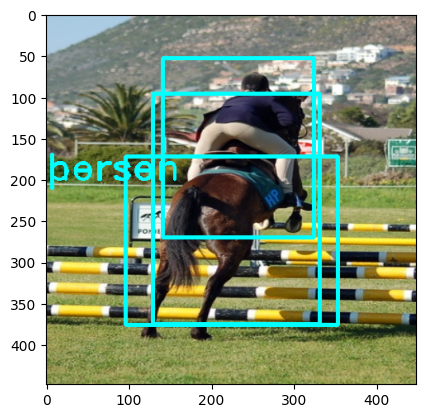

In [23]:
np_img = cv2.imread('./data/VOCdevkit_test/VOC2007/JPEGImages/000010.jpg')
resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
# np_img = np_img / 255.0 * 2 - 1

# Remember to replace this line to the corresponding preprocess_input function!!!
np_img = pretrained_model_preprocess_input(np_img)
np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

y_pred = YOLO(np_img, training=False)

for xmin, ymin, xmax, ymax, class_num, conf in process_outputs(y_pred, multiple_output=True, conf_score_threshold=0.5):
    class_name = classes_name[class_num]
    cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3)
    cv2.putText(resized_img, class_name, (0, 200), 2, 1.5, (0, 255, 255), 2)
    print("{}: {}".format(class_name, conf))

plt.imshow(resized_img)
plt.show()